# Scalable Data Access and Upload

In this notebook you will access data using the Scenes API and upload data back to the DL Data Catalog using the Catalog API. Streamlined data access is core to the DL Enterprise Accelerator. To demonstrate the basics of accessing, transforming, and uploading data we will be constructing a cloud-free Sentinel-2 L2A NDVI composite over an area in the corn-belt of the United States (Iowa specifically). 

We will use the following DL API's in this exercise:
- [Scenes](https://docs.descarteslabs.com/descarteslabs/scenes/readme.html) - Query for and access imagery over our AOI
- [Catalog](https://docs.descarteslabs.com/descarteslabs/catalog/readme.html) - Create Catalog product and bands to upload our composite back to the platform

We will use the following external Python packages:
- [geopandas](https://geopandas.org/en/stable/docs.html) - Import, transform, and query our reference dataset for Iowa agricultural fields
- [shapely](https://shapely.readthedocs.io/en/stable/) - Generate AOI using our fields reference dataset
- [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) - CRS aware plotting
- [affine](https://github.com/rasterio/affine) - Translate metadata returned from Scenes into usable Affine transform for plotting
- [matplotlib.pyplot](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.html) - Plot imagery
- [numpy](https://numpy.org/doc/stable/index.html) - Array/imagery operations and manipulations
- [uuid](https://docs.python.org/3/library/uuid.html) - Generate unique identifier for avoiding duplicate Catalog products across and organization

In [4]:
import descarteslabs as dl
import geopandas as gpd
import shapely.geometry as sg
from rasterio.plot import show
from affine import Affine
import matplotlib.pyplot as plt
import numpy as np
import uuid

## Loading reference data

We start off by downloading a reference dataset that will be used through the rest of these notebooks. This reference data is field boundaries and associated metadata for agricultural fields in Iowa for the year of 2019. We use `wget` to pull the data from the USDA and the unzip the data into our `../data` folder.

In [ ]:
!mkdir ../data

In [ ]:
!wget -O ../data/IA_ACPFfields2019.zip https://data.nal.usda.gov/system/files/IA_ACPFfields2019.zip

In [ ]:
!unzip -o ../data/IA_ACPFfields2019.zip -d ../data

The following files should now be found in `../data`:
```
..
|-- data
    |-- IA_ACPFfields2019.zip
    |-- IowaFieldBoundaries2019.cpg
    |-- IowaFieldBoundaries2019.dbf
    |-- IowaFieldBoundaries2019.prj
    |-- IowaFieldBoundaries2019.sbn
    |-- IowaFieldBoundaries2019.sbx
    |-- IowaFieldBoundaries2019.shp
    |-- IowaFieldBoundaries2019.shp.xml
    |-- IowaFieldBoundaries2019.shx
    |-- IA_ACPFfields_CropHistory2010_2019.csv
    |-- IA_ACPFfields_CropHistory2010_2019.txt.html
    |-- IA_ACPFfields_LandUse2014_2019.csv
    |-- IA_ACPFfields_LandUse2014_2019.txt.xml
```

Now that we have downloaded the data let's pull it into this notebook using Geopandas. To do this we simply use `gpd.read_file()` on the shapefile we just downloaded.

In [5]:
ia_fields = gpd.read_file("../data/IowaFieldBoundaries2019.shp")

In [6]:
print(len(ia_fields))

717938


For this notebook we will look at a small subset of the 718 thousands fields in the dataset we just downloaded. We convert that sample to the EPSG 4326 CRS. This will simplify working with the Scenes API.

In [7]:
ia_test_fields = ia_fields.iloc[:100].to_crs("EPSG:4326")

We can then delete the remaining fields from memory to keep things tidy.

In [8]:
ia_fields = None

We can then construct an small bounding box containing the 100 fields we selected. This bounding box will serve as our AOI for accessing data with Scenes.

In [9]:
ia_test_aoi = sg.box(*list(ia_test_fields.geometry.total_bounds))

The field geometries (blue) and AOI (red) can be plotted below.

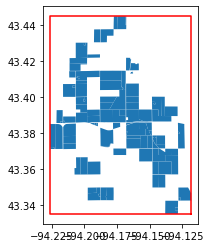

In [13]:
ia_test_fields.plot()
plt.plot(*ia_test_aoi.exterior.xy, color="red")

## Searching for imagery

With our AOI ready we can now search for and access imagery using Scenes. There are a few other parameters we can specify to filter what imagery we would like to access:
- product - A DL Catalog product string specifying which unique product we would like to access data from
- start_datetime - The beginning of the date range we would like to find imagery in
- end_datetime - The end of the date range we would like to find imagery in

In [15]:
product = "esa:sentinel-2:l2a:v1"
start_datetime = "2019-03-01"
end_datetime = "2019-10-01"

We can plug in our AOI, product, start and end datetimes to the `dl.scenes.search()` function to find imagery meeting the specified arguments. We also specify `limit=None` and `cloud_fraction=0.25` to allow us to access as many scenes as are available that have an overall cloud fraction less than or equal to 25%. Cloud fraction here means the percent of an image that is covered by clouds.

In [16]:
scenes, ctx = dl.scenes.search(
    ia_test_aoi,
    products=product,
    start_datetime=start_datetime,
    end_datetime=end_datetime,
    limit=None,
    cloud_fraction=0.25
)

We get a `SceneCollection` and `GeoContext` back from the `dl.scenes.search()` call. The `SceneCollection` object contains metadata about the scenes we queried and methods for accessing those scenes. The `GeoContext` has information about the CRS, resolution, bounds, and shape associated with the AOI we specified and the underlying imagery we queried. The `GeoContext` is used to specify what scale, coordinate system, and over what area we want our imagery to be resampled, transformed, and clipped to. By default a `dl.scenes.search()` call will return a `GeoContext` with the native resolution and coordinate system of the imagery we are accessing. You can adjust these components of the `GeoContext` using the `assign()` method. For this notebook we will use the native resolution and CRS.

In [17]:
scenes

SceneCollection of 100 scenes
  * Dates: Mar 08, 2019 to Sep 24, 2019
  * Products: esa:sentinel-2:l2a:v1: 100

In [18]:
ctx

AOI(geometry=<shapely.geom...x7fde9c5dc0d0>,
    resolution=10.0,
    crs='EPSG:32615',
    align_pixels=True,
    bounds=(-94.2263107328164, 43.33486224652304, -94.11822520742787, 43.44477787264371),
    bounds_crs='EPSG:4326',
    shape=None)

A `SceneCollection` contains metadata about the query you made using `dl.scenes.search()` as well as a series of `Scenes` objects each with their own metadata and methods. We can access this metadata using `SceneCollection.properties` which will list the metadata/properties for each fo the collections individual `Scenes`. This is useful for extracting information like a list of acquisition dates for all the images we queried.

In [19]:
dates = [key for key, scene in scenes.groupby(lambda x: x.properties.date.strftime("%Y-%m-%d"))]

In [21]:
print(dates)

['2019-03-08', '2019-03-11', '2019-03-16', '2019-03-18', '2019-03-21', '2019-03-26', '2019-03-31', '2019-04-02', '2019-04-15', '2019-04-20', '2019-05-05', '2019-05-10', '2019-05-15', '2019-05-22', '2019-05-25', '2019-06-01', '2019-06-06', '2019-06-29', '2019-07-04', '2019-07-06', '2019-07-11', '2019-07-14', '2019-07-19', '2019-07-24', '2019-07-26', '2019-07-29', '2019-08-03', '2019-08-08', '2019-08-10', '2019-08-13', '2019-08-18', '2019-08-20', '2019-08-23', '2019-08-28', '2019-08-30', '2019-09-04', '2019-09-17', '2019-09-24']


A `SceneCollection` can also be filtered by the various properties of its constituent `Scenes`. This is done using `SceneCollection.filter()` and either a predicate string of the form "properties.property" or using a lambda function (lambda x: x.properties.property). `SceneCollection`s can also be grouped based on properties using the `SceneCollection.groupby()` method. We won't be filtering or grouping the scenes in our collection for the sake of simplicity.

## Accessing imagery

Now that we have queried the available imagery we can access the actual raster data.

A `Scene` has two methods for pulling an image locally:
- `.ndarray()` - Pulls the image data into a 3D numpy.ndarray of shape *(n bands, xs, ys)*
- `.download()` - Downloads the image data down into a .geotiff at a specified filepath

A `SceneCollection` has a variety of methods that allow you to pull imagery into your local environment:
- `.stack()` - Pulls each individual image in parallel and stacks them all into a 4D array of shape *(n images, n bands, xs, ys)*
- `.mosaic()` - Pulls all images into a single 3D array where the values are populated using the "top-most" image in the collection (specified by the last image in the `SceneCollection`)
- `.download()` - Downloads each image into a .geotiff in parallel
- `download_modaic()` - Downloads a single mosaic into a .geotiff using the same logic as `.mosaic()`

We will be using `.stack()` to create a 4D array of our queried imagery. We need to specify a few arguments for this method. We specify which bands we want to access (in this case the red and near infrared bands). We also want the cloud mask band to remove any cloudy pixels from our final composite. We specify that we want to mosaic images from the same aquisition day using the `flatten` kwarg. This will mean that the output array will have shape *(time/day, n bands, xs, ys)*. We also want to have the `.stack()` call to return some raster metadata that we can use for plotting our raster and vector data together. The final thing we specify is our "scaling". For this example we want reflectance values between 0-1.0. To do this we set `scaling="physical"`. For more info on scaling parameters please see [here](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scene.html#descarteslabs.scenes.scene.Scene.scaling_parameters).

In [22]:
bands = ["red", "nir"]

In [23]:
stack, meta = scenes.stack(
    bands+["cloud_mask"],
    ctx,
    flatten=lambda x: x.properties.date.strftime("%Y-%m-%d"),
    raster_info=True,
    scaling="physical"
)

In [24]:
stack.shape

(38, 3, 1234, 894)

With our imagery now pulled locally into an ndarray we can proceed to mask out any cloud pixels and compute NDVI (Normalized Difference Vegetation Index; a representation of crop health). NDVI can be computed using
**(nir-red)/(nir + red)**.

In [25]:
stack.mask = (stack.mask) | np.repeat((stack[:,-1].data==1)[:, np.newaxis], stack.shape[1], axis=1)

In [26]:
red = stack[:,0]
nir = stack[:,1]

In [27]:
ndvi = (nir - red)/(nir + red)

In [28]:
stack=None

In [29]:
ndvi.shape

(38, 1234, 894)

We now build our maximum NDVI composite by using the `.max()` method on our stack.

In [33]:
max_ndvi = ndvi.max(axis=0)

As mentioned before we can pull some useful metadata from the returned raster_info to use for plotting with rasterio.plot.show. We also use this infor for plotting the reference fields subset we used to construct out AOI.

In [31]:
epsg_str = f"EPSG:{meta[0]['coordinateSystem']['epsg']}"
af_transform = Affine.from_gdal(*meta[0]["geoTransform"])

(400580.0, 409520.0, 4798600.0, 4810940.0)

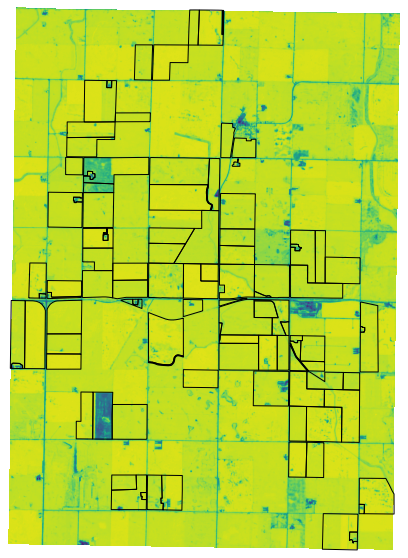

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

show(
    max_ndvi,
    transform=af_transform,
    ax=ax
)

ia_test_fields.to_crs(epsg_str).plot(
    facecolor="None",
    edgecolor="black", 
    ax=ax
)
ax.axis("off")

## Data upload

We often would like to persist composites, intermediate datasets, or data processing results in a product in the DL Catalog. In this final section of the notebook we will create a Catalog product, specify that band(s) associated with the product, and upload an image to the product.

We create a product by instantiating a `dl.catalog.Product` object. More specifically we use either the `.create()` or `.get_or_create()` methods to create a product with a specified unique id. We specify a name and description by directly setting the `.name` and `.description` attributes of our `Product` object. Finally we save the `Product` object. This submits the specified product to the DL Catalog and create the product on the DL backend.

Products are created in the namespace of the organization you belong to. Because of this you can run into a scenario where one individual user at an org tries to make a Catalog product but that Catalog product is said to "already exist". This will throw an error letting the user know that there is already a product in the Catalog with the same specified id and org. Because of this we will use a unique identifier in the product id to make sure you don't run into the aforementioned error. Generally this unique id will not be necessary for Enterprise Accelerator users as the final products you use should likely be created by (and therefore owned by) the same service account.

In [35]:
random_id = str(uuid.uuid4())[:8]

In [ ]:
product = dl.catalog.Product.get_or_create(f"{random_id}_s2_2019_ndvi_comps")
product.name = "S2 2019 NDVI composites"
product.description = "NDVi composites for the 2019 growing season"
product.save()

With our product specified and saved we must now specify what each of the bands in the product are. We do this with the `dl.catalog.GenericBand` object. There are other more specific types of band objects that you can find more info on [here](https://docs.descarteslabs.com/descarteslabs/catalog/docs/band.html). To create a band you can use `.create` or `.get_or_create`. There are many parameters that need to be defined for a band, including the index in you uploaded data corresponding to the band, [the data type](https://docs.descarteslabs.com/descarteslabs/catalog/docs/types.html#descarteslabs.catalog.DataType), data values range, default range to display values over, no data value, and the resolution (using the `dl.catalog.Resolution` object. A band, much like a product, only needs to be specified once (not each time you upload a new image).

In [ ]:
band = dl.catalog.GenericBand.get_or_create(
    id=f'{product.id}:max_ndvi',
    description="Maximum NDVI",
    band_index=0,
    sort_order=0,
    data_type=dl.catalog.DataType.FLOAT32,
    data_range=[-1.0, 1.0],
    display_range=[0, 0.8],
    nodata=-999,
    resolution=dl.catalog.Resolution(value=10., unit=dl.catalog.ResolutionUnit.METERS),
)
band.save()
print(band.id)

With our band saved we can now specify and upload our image. We use the `dl.catalog.Image` object, providing the `Product` object and a unique image id `name=...`. We also specify the acquisition date (the end of our composite's date range), the geotransform (from our raster metadata/info), and the crs (again from our raster info). The image is then uploaded using `Image.upload_ndarray()` specifying the array to upload, if we want overviews to be generated, and whether or not to overwrite existing images with the same name as our new image. It should be noted that you can upload a geotiff directly using [this method](https://docs.descarteslabs.com/descarteslabs/catalog/docs/image.html#descarteslabs.catalog.Image.upload) instead.

In [ ]:
image = dl.catalog.Image(product=product, name=f"ia_2019_test_aoi_max_ndvi")
image.acquired = end_date
image.geotrans = meta[0]["geoTransform"]
image.cs_code = epsg_str
    
upload = image.upload_ndarray(
    max_ndvi,
    overviews=[2, 8, 32],
    overview_resampler=dl.catalog.OverviewResampler.NEAREST,
    overwrite=True
)
    
upload.wait_for_completion()
print(upload.status)

We wait for the upload to complete and print out the status of the upload to see if any errors occured. We can then go to our new product in the Catalog UI [here](https://catalog.descarteslabs.com/?/filter/my) to view our product, bands, and uploaded image.